In [1]:
import torch
import math
import matplotlib.pyplot as plt

In [2]:
def train_neuron_batch(features, labels, initial_weights, initial_bias, learning_rate, epochs):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
    weights = torch.tensor(initial_weights, dtype=torch.float32).reshape(-1, 1)
    bias = torch.tensor(initial_bias, dtype=torch.float32)

    n_samples = features_tensor.shape[0]
    nll_values = []
    epsilon = 1e-8

    for epoch in range(epochs):
        z = torch.mm(features_tensor, weights) + bias
        a = 1 / (1 + torch.exp(-z))

        log_a = torch.log(a + epsilon)
        log_1_minus_a = torch.log(1 - a + epsilon)
        loss = -torch.mean(labels_tensor * log_a + (1 - labels_tensor) * log_1_minus_a)
        
        nll_values.append(round(loss.item(), 4))

        error = a - labels_tensor
        
        grad_weights = (1 / n_samples) * torch.mm(features_tensor.T, error)
        grad_bias = (1 / n_samples) * torch.sum(error)

        weights -= learning_rate * grad_weights
        bias -= learning_rate * grad_bias

    return weights.flatten().tolist(), bias.item(), nll_values

In [3]:
torch.manual_seed(42)
features_y1_c0 = torch.randn(50, 2) - 2
features_y1_c1 = torch.randn(50, 2) + 2
features_y1 = torch.cat([features_y1_c0, features_y1_c1]).tolist()
labels_y1 = [0]*50 + [1]*50

torch.manual_seed(101)
features_y2_c0 = torch.randn(50, 2) * 1.2 - 1.5
features_y2_c1 = torch.randn(50, 2) * 1.2 + 1.5
features_y2 = torch.cat([features_y2_c0, features_y2_c1]).tolist()
labels_y2 = [0]*50 + [1]*50

In [4]:
initial_weights = [0.1, -0.2]
initial_bias = 0.0
learning_rate = 0.1
epochs = 50

print("--- Обучение на наборе данных 'Год 1' ---")
w1, b1, nll1 = train_neuron_batch(
    features_y1, labels_y1, initial_weights, initial_bias, learning_rate, epochs)
print(f"Обновленные веса: {[round(x, 4) for x in w1]}")
print(f"Обновленное смещение: {round(b1, 4)}")
print(f"Значения NLL (последние 5 эпох): {nll1[-5:]}")

print("\n" + "="*40 + "\n")

print("--- Обучение на наборе данных 'Год 2' ---")
w2, b2, nll2 = train_neuron_batch(
    features_y2, labels_y2, initial_weights, initial_bias, learning_rate, epochs)
print(f"Обновленные веса: {[round(x, 4) for x in w2]}")
print(f"Обновленное смещение: {round(b2, 4)}")
print(f"Значения NLL (последние 5 эпох): {nll2[-5:]}")

--- Обучение на наборе данных 'Год 1' ---
Обновленные веса: [1.0205, 0.817]
Обновленное смещение: -0.0053
Значения NLL (последние 5 эпох): [0.0579, 0.057, 0.0562, 0.0554, 0.0546]


--- Обучение на наборе данных 'Год 2' ---
Обновленные веса: [0.8527, 1.0029]
Обновленное смещение: 0.0623
Значения NLL (последние 5 эпох): [0.139, 0.1378, 0.1366, 0.1354, 0.1343]


сравним с sgd

In [5]:
def train_neuron_sgd(features, labels, initial_weights, initial_bias, learning_rate, epochs):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)
    weights = torch.tensor(initial_weights, dtype=torch.float32)
    bias = torch.tensor(initial_bias, dtype=torch.float32)

    n_samples = features_tensor.shape[0]
    nll_values = []
    epsilon = 1e-8

    for epoch in range(epochs):
        perm = torch.randperm(n_samples)
        shuffled_features = features_tensor[perm]
        shuffled_labels = labels_tensor[perm]

        for i in range(n_samples):
            feature_i = shuffled_features[i]
            label_i = shuffled_labels[i]

            z = torch.dot(feature_i, weights) + bias
            a = 1 / (1 + torch.exp(-z))
            
            error = a - label_i
            grad_weights = error * feature_i
            grad_bias = error
            
            weights -= learning_rate * grad_weights
            bias -= learning_rate * grad_bias

        z_full = torch.mv(features_tensor, weights) + bias
        a_full = 1 / (1 + torch.exp(-z_full))
        
        loss = -torch.mean(
            labels_tensor * torch.log(a_full + epsilon) +
            (1 - labels_tensor) * torch.log(1 - a_full + epsilon)
        )
        nll_values.append(round(loss.item(), 4))

    return weights.tolist(), bias.item(), nll_values

--- Сравнение сходимости на наборе 'Год 2' ---


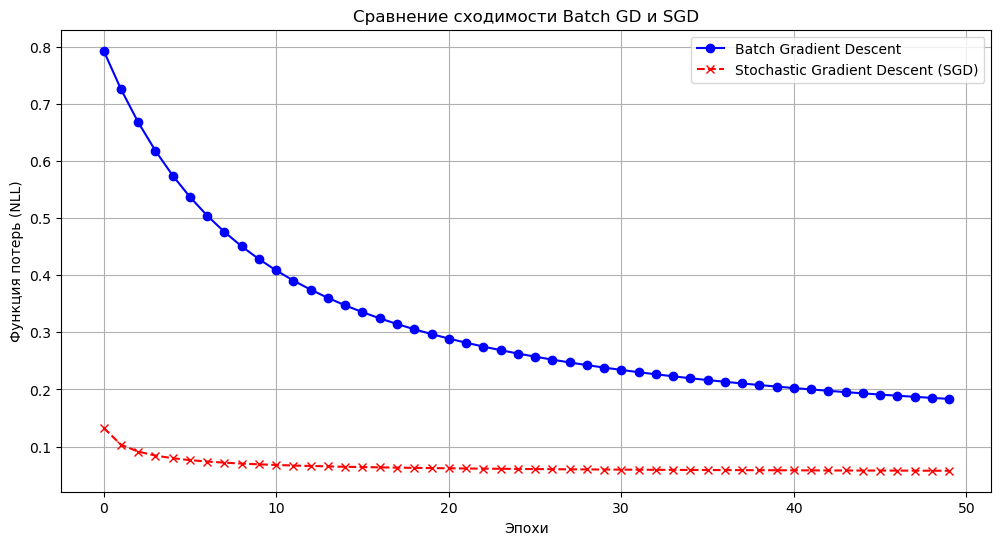

In [6]:
epochs_comp = 50
lr_comp = 0.05

print("--- Сравнение сходимости на наборе 'Год 2' ---")

w_batch, b_batch, nll_batch = train_neuron_batch(
    features_y2, labels_y2, initial_weights, initial_bias, lr_comp, epochs_comp)

w_sgd, b_sgd, nll_sgd = train_neuron_sgd(
    features_y2, labels_y2, initial_weights, initial_bias, lr_comp, epochs_comp)

plt.figure(figsize=(12, 6))
plt.plot(range(epochs_comp), nll_batch, label='Batch Gradient Descent', color='blue', marker='o', linestyle='-')
plt.plot(range(epochs_comp), nll_sgd, label='Stochastic Gradient Descent (SGD)', color='red', marker='x', linestyle='--')
plt.title('Сравнение сходимости Batch GD и SGD')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь (NLL)')
plt.legend()
plt.grid(True)
plt.show()